## Reading a so6 file

In [ ]:
# Reading a zipped file (with libarchive)
from traffic.data.so6 import SO6
so6 = SO6.from_file("../data/20180101_20180101_0000_2359_____m3.so6.7z")

# Serialize 
so6.to_pickle("../data/20180101_20180101_0000_2359_____m3.pkl")

In [1]:
# Read the serialized version
from traffic.data.so6 import SO6
so6 = SO6.from_file("../data/20180101_20180101_0000_2359_____m3.pkl")

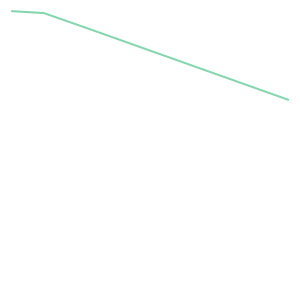

In [2]:
# Access a flight with brackets (and completion)
so6['HOP36PP']

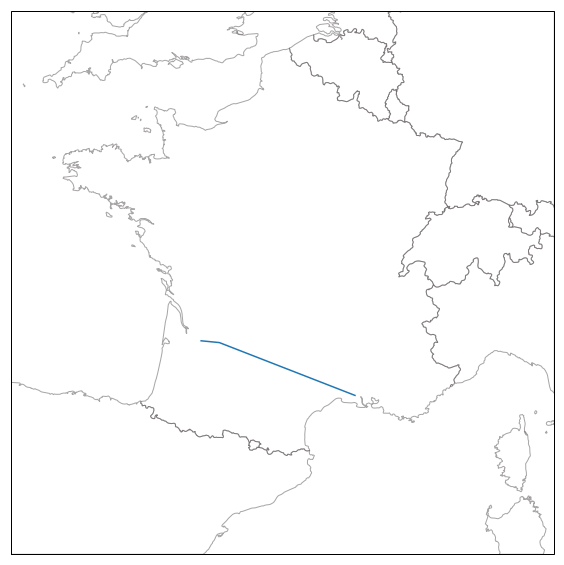

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

from traffic.drawing import Lambert93, countries

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=Lambert93())
ax.set_default_extent()

ax.add_feature(countries())
so6['HOP36PP'].plot(ax)

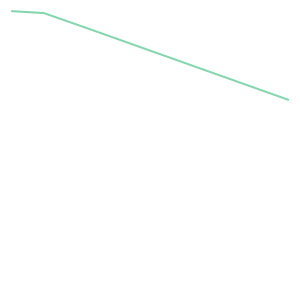

In [4]:
# Access with unique id
so6[332206265]

In [5]:
# A pandas DataFrame is hidden behind
so6['HOP36PP'].data.head()

,origin,destination,aircraft,alt1,alt2,callsign,lat1,lon1,lat2,lon2,flight_id,time1,time2
65794,LFML,LFBD,A319,21800,27600,HOP36PP,43.608398,4.527325,44.543555,1.178150,332206265,2018-01-01 19:15:40,2018-01-01 19:44:50
65795,LFML,LFBD,A319,27600,17500,HOP36PP,44.543555,1.178150,44.726898,0.460837,332206265,2018-01-01 19:44:50,2018-01-01 19:52:10
65796,LFML,LFBD,A319,17500,9500,HOP36PP,44.726898,0.460837,44.751343,-0.091422,332206265,2018-01-01 19:52:10,2018-01-01 19:58:00


In [6]:
# Does the aircraft fly through the sector?
from traffic.data import sectors
so6['HOP36PP'].intersects(sectors['LFBBBDX'])

True

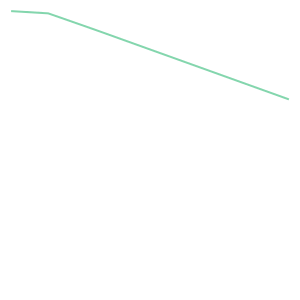

In [7]:
# Clip the flight on the 2D polygon of the sector
so6['HOP36PP'].clip(sectors['LFBBBDX'].flatten())

## Interpolation and temporal filtering

In [8]:
# Interpolation at a given date (str (UTC), int (timestamp) or datetime)
so6['HOP36PP'].at("2018/01/01 18:40")

array([[  1.73315595e+00,   4.43885865e+01,   2.66388571e+04]])

In [9]:
# Interpolation inside a given interval
so6['HOP36PP'].between("2018/01/01 18:25", "2018/01/01 18:55").data

,lon1,lat1,alt1,lon2,lat2,alt2,aircraft,callsign,destination,flight_id,origin,time1,time2
0,3.455589,43.907649,23656.0,1.178150,44.543555,27600.000000,A319,HOP36PP,LFBD,332206265,LFML,2018-01-01 19:25:00,2018-01-01 19:44:50
1,1.178150,44.543555,27600.0,0.460837,44.726898,17500.000000,A319,HOP36PP,LFBD,332206265,LFML,2018-01-01 19:44:50,2018-01-01 19:52:10
2,0.460837,44.726898,17500.0,0.192597,44.738771,13614.285714,A319,HOP36PP,LFBD,332206265,LFML,2018-01-01 19:52:10,2018-01-01 19:55:00


In [10]:
# also with timedelta
from datetime import timedelta
so6['HOP36PP'].between("2018/01/01 18:25", timedelta(minutes=30)).data

,lon1,lat1,alt1,lon2,lat2,alt2,aircraft,callsign,destination,flight_id,origin,time1,time2
0,3.455589,43.907649,23656.0,1.178150,44.543555,27600.000000,A319,HOP36PP,LFBD,332206265,LFML,2018-01-01 19:25:00,2018-01-01 19:44:50
1,1.178150,44.543555,27600.0,0.460837,44.726898,17500.000000,A319,HOP36PP,LFBD,332206265,LFML,2018-01-01 19:44:50,2018-01-01 19:52:10
2,0.460837,44.726898,17500.0,0.192597,44.738771,13614.285714,A319,HOP36PP,LFBD,332206265,LFML,2018-01-01 19:52:10,2018-01-01 19:55:00


In [11]:
# intersection within a time interval
so6['HOP36PP'].between("2018/01/01 18:25", timedelta(minutes=30)).intersects(sectors['LFBBBDX'])

True

In [12]:
# The flight entered the sector earlier
so6['HOP36PP'].between("2018/01/01 18:15", timedelta(minutes=5)).intersects(sectors['LFBBBDX'])

False

## Spatial filtering

In [13]:
# Number of flights
len(so6)

11043

In [14]:
%%time
# First, filter inside the bounding box (faster than polygon check)
bdx_so6 = so6.inside_bbox(sectors["LFBBBDX"])

CPU times: user 5.07 s, sys: 19.4 ms, total: 5.09 s
Wall time: 5.11 s


In [15]:
len(bdx_so6)

1548

In [16]:
%%time
noon = so6.at("2018/01/01 12:00")

CPU times: user 4.05 ms, sys: 2 µs, total: 4.05 ms
Wall time: 3.64 ms


In [17]:
%%time
# usually faster, but not necessarily safe on small sectors...
bdx_flights = noon.inside_bbox(sectors['LFBBBDX']).intersects(sectors['LFBBBDX'])

CPU times: user 1.07 s, sys: 3.5 ms, total: 1.07 s
Wall time: 1.08 s


## Misc.

In [18]:
# Check a callsign is inside a so6
'HOP32SS' in so6.callsigns

False

In [19]:
# Number of lines per flight
len(so6['HOP36PP'])

3

In [20]:
so6['HOP12VY'].coords

<generator object coords at 0x7f52bc660f68>

In [21]:
# Advanced: get coordinates (also LineString)
import numpy as np
np.stack(so6['HOP12VY'].coords)[:5, :]

array([[  1.59301758e-01,   4.35558099e+01,   1.18000000e+04],
       [  4.48697718e-01,   4.48324585e+01,   2.98000000e+04],
       [  9.47364807e-01,   4.69432068e+01,   2.89000000e+04],
       [  1.57856188e+00,   4.82308184e+01,   1.11000000e+04],
       [  1.90267710e+00,   4.85295410e+01,   1.09000000e+04]])

In [22]:
# also LineString (but no altitude :())
so6['HOP12VY'].linestring.xy

(array('d', [0.15930175781199998, 0.44869771817799997, 0.9473648071290001, 1.57856188322, 1.9026770958499999, 2.3891649748100003, 2.80042949476, 2.8312201248999997, 2.6234917891700005]),
 array('d', [43.555809926200006, 44.8324584961, 46.9432067871, 48.230818409, 48.529541015599996, 48.566273834700006, 48.6719939668, 48.7238531598, 48.754251771099995]))

In [24]:
# Get timestamps
np.stack(so6['HOP12VY'].timestamp)[:5]

array([Timestamp('2018-01-01 11:25:10'), Timestamp('2018-01-01 11:37:50'),
       Timestamp('2018-01-01 11:57:30'), Timestamp('2018-01-01 12:10:10'),
       Timestamp('2018-01-01 12:13:50')], dtype=object)

In [25]:
np.stack(so6['HOP12VY'].coords)[:,2]

array([ 11800.,  29800.,  28900.,  11100.,  10900.,  10900.,   7000.,
         5400.,   5400.])

In [26]:
min_ = 10000
max_ = 20000

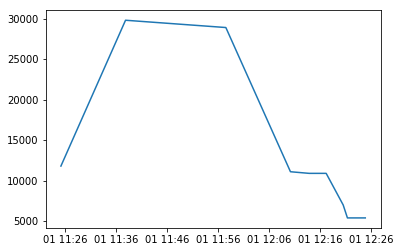

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(list(so6['HOP12VY'].timestamp), np.stack(so6['HOP12VY'].coords)[:,2])

In [28]:
np.stack(so6['HOP12VY'].coords)[:,2]

array([ 11800.,  29800.,  28900.,  11100.,  10900.,  10900.,   7000.,
         5400.,   5400.])

In [29]:
from IPython.display import display

for subtab in so6['HOP12VY'].clip_altitude(10000, 20000):
    display(subtab)

,origin,destination,aircraft,alt1,alt2,callsign,lat1,lon1,lat2,lon2,flight_id,time1,time2
0,LFBT,LFPO,F100,11800,20000,HOP12VY,43.55581,0.159302,44.137837,0.289737,274485420,2018-01-01 11:25:10,2018-01-01 11:37:50


,origin,destination,aircraft,alt1,alt2,callsign,lat1,lon1,lat2,lon2,flight_id,time1,time2
0,LFBT,LFPO,F100,20000,11100,HOP12VY,47.587996,1.259658,48.230818,1.578562,274485420,2018-01-01 11:57:30,2018-01-01 12:10:10
1,LFBT,LFPO,F100,11100,10900,HOP12VY,48.230818,1.578562,48.529541,1.902677,274485420,2018-01-01 12:10:10,2018-01-01 12:13:50
2,LFBT,LFPO,F100,10900,10900,HOP12VY,48.529541,1.902677,48.566274,2.389165,274485420,2018-01-01 12:13:50,2018-01-01 12:17:10
3,LFBT,LFPO,F100,10900,10000,HOP12VY,48.566274,2.389165,48.590784,2.483944,274485420,2018-01-01 12:17:10,2018-01-01 12:20:30
